In [4]:
import copy
import numpy as np
import pandas as pd
import qiime2 as q2
from biom import Table
from scipy.stats import ttest_ind
from qiime2.plugins.deicode.actions import rpca
from qiime2.plugins.emperor.actions import biplot, plot

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [5]:
# abund.
contig_abund = pd.read_csv('data/metagenomics/pathway-gene/contig-abundance-RPK.tsv',
                        sep='\t', index_col=0)
contig_abund.index = [x.split('_cov')[0] for x in contig_abund.index]
contig_abund = contig_abund.groupby(contig_abund.index).sum()
btcontig_abund = Table(contig_abund.values, contig_abund.index, contig_abund.columns)
q2contig_abund = q2.Artifact.import_data('FeatureTable[Frequency]', btcontig_abund)

contig_expression = pd.read_csv('data/metagenomics/pathway-gene/contig-transcription-RPK.tsv',
                             sep='\t', index_col=0)
contig_expression.index = [x.split('_cov')[0] for x in contig_expression.index]
contig_expression = contig_expression.groupby(contig_expression.index).sum()
btcontig_expression = Table(contig_expression.values, contig_expression.index, contig_expression.columns)
q2contig_expression = q2.Artifact.import_data('FeatureTable[Frequency]', btcontig_expression)
# annots
functional_mapping = pd.read_csv('data/metagenomics/pathway-gene/grouped-annotations.gff',
                                 sep='\t', index_col=0)
# drop hypothetical
functional_mapping = functional_mapping[~functional_mapping['product'].isin(['hypothetical protein'])]
functional_mapping.head(5)


,bin_id,contig,source,region,start,end,score,strand,phase,attributes,locus_tag,ftype,length_bp,gene,EC_number,COG,product
0,bin.1,NODE_18226_length_2784,Prodigal:2.6,CDS,223,597,.,+,0,ID=HGCCDMHB_00001;Name=fhaB;dbxref=COG:COG1716...,HGCCDMHB_00001,CDS,375,fhaB,NaN,COG1716,FHA domain-containing protein FhaB
1,bin.1,NODE_18226_length_2784,Prodigal:2.6,CDS,600,2738,.,-,0,ID=HGCCDMHB_00002;eC_number=2.4.1.161;dbxref=C...,HGCCDMHB_00002,CDS,2139,NaN,2.4.1.161,COG1501,Oligosaccharide 4-alpha-D-glucosyltransferase
3,bin.1,NODE_3670_length_8626,Prodigal:2.6,CDS,1841,3634,.,-,0,ID=HGCCDMHB_00004;Name=lipO;dbxref=COG:COG1653...,HGCCDMHB_00004,CDS,1794,lipO,NaN,COG1653,Lipoprotein LipO
4,bin.1,NODE_3670_length_8626,Prodigal:2.6,CDS,3711,4676,.,-,0,ID=HGCCDMHB_00005;Name=araQ_1;dbxref=COG:COG03...,HGCCDMHB_00005,CDS,966,araQ_1,NaN,COG0395,L-arabinose transport system permease protein ...
5,bin.1,NODE_3670_length_8626,Prodigal:2.6,CDS,4694,6154,.,-,0,ID=HGCCDMHB_00006;Name=yteP;dbxref=COG:COG4209...,HGCCDMHB_00006,CDS,1461,yteP,NaN,COG4209,putative multiple-sugar transport system perme...


In [6]:
# self-annotated AMP-forming acetyl-CoA synthetase (AMP-ACS)
self_ec = {'6.2.1.1':['NODE_565_length_51453','NODE_788_length_39285',
                        'NODE_3198_length_10761','NODE_1043_length_30874',
                        'NODE_3198_length_10761','NODE_1891_length_17783',
                        'NODE_1891_length_17783','NODE_5829_length_6239',
                        'NODE_26441_length_1870','NODE_13921_length_3067',
                        'NODE_526_length_54157']}

ratiosdfs = []
for ec_ in ['1.1.1.1','1.2.1.10', '2.7.2.1','2.3.1.8','6.2.1.1']:

    ind_ = functional_mapping[functional_mapping.EC_number.isin([ec_])].contig.values
    housekeeper = functional_mapping[functional_mapping.gene.isin(['rpoA'])].contig.values

    if ec_ in self_ec.keys():
        ind_ = self_ec[ec_]
    
    num = contig_abund.loc[ind_, :].dropna().sum(axis=0).values + 1
    den = contig_abund.loc[housekeeper, :].dropna().sum(axis=0) + 1
    abund = np.log(num) - np.log(den)

    num = contig_expression.loc[ind_, :].dropna().sum(axis=0).values + 1
    den = contig_expression.loc[housekeeper, :].dropna().sum(axis=0) + 1
    expres = np.log(num) - np.log(den)

    ratiosdf = pd.concat([abund, expres], axis=1)
    ratiosdf.columns = ['abundance','expression']
    ratiosdf_etoh = ratiosdf.copy().stack().reset_index()
    ratiosdf_etoh.columns = ['sample','type','log-ratio']
    ratiosdf_etoh['treatment'] = [v.split('_')[0]
                                  for v in ratiosdf_etoh['sample']]
    ratiosdf_etoh['step'] = ec_
    ratiosdfs.append(ratiosdf_etoh)
ratiosdf = pd.concat(ratiosdfs, axis=0)
ratiosdf.head(3)

/Users/cmartino/miniconda3/envs/qiime2-2019.10-FEAST/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,sample,type,log-ratio,treatment,step
0,Control_3_S6,abundance,0.521233,Control,1.1.1.1
1,Control_3_S6,expression,-0.451011,Control,1.1.1.1
2,Control_1_S4,abundance,-0.431807,Control,1.1.1.1


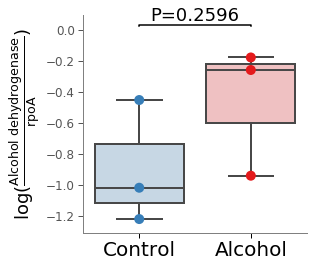

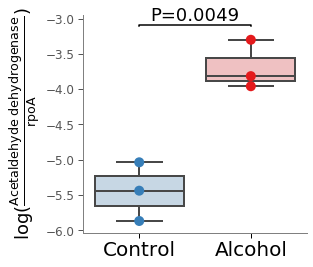

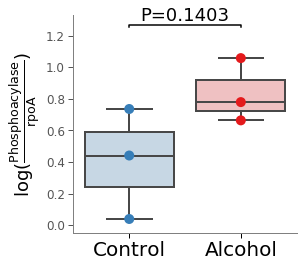

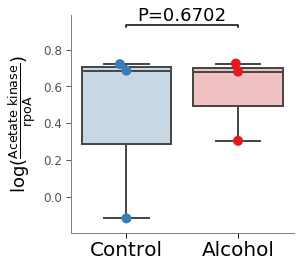

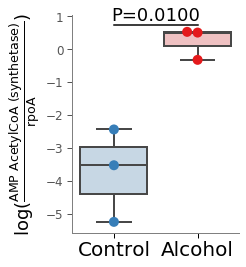

In [8]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 25}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 12
pallet_ = {'Control':'#377eb8',
           'Alcohol':'#e41a1c'}

labels_ = {'1.1.1.1':'Alcohol dehydrogenase' ,
           '1.2.1.10':'Acetaldehyde dehydrogenase',
           '2.7.2.1':'Acetate kinase',
           '2.3.1.8':'Phosphoacylase',
           '6.2.1.1':'AMP AcetylCoA (synthetase)'}

for step_, mf_lr in ratiosdf.groupby('step'):
    
    if step_=='6.2.1.1':
        fig, ax = plt.subplots(1,1, figsize=(3,4))
    else:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    
    # only expression
    mf_lr = mf_lr[mf_lr.type.isin(['expression'])]

    # plotting.
    sns.swarmplot(y='log-ratio', x='treatment',
                data=mf_lr, palette=pallet_,
                ax=ax, s=10)
    sns.boxplot(y='log-ratio',x='treatment',
                data=mf_lr,
                ax=ax, palette=pallet_,)
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    # title etc ... 
    #ax.set_title(step_ + ' Expression', y=1.1, fontsize=22)
    ax.set_xlabel('', fontsize=25)
    #if title_ == 'Bin-Abundance':
    ax.set_ylabel('$\\log(\\frac{\\mathrm{%s}}{\\mathrm{%s}})$' 
                  % (labels_[step_].replace(' ','\,\,'),
                     'rpoA'),
                  fontsize=18, color='black')
    #else:
    #    ax.set_ylabel('')
    # statistical annotation
    t_res = ttest_ind(mf_lr[mf_lr.treatment.isin(['Control'])]['log-ratio'].values,
                      mf_lr[mf_lr.treatment.isin(['Alcohol'])]['log-ratio'].values)
    p_ = 'P=%.4f' % (t_res.pvalue)
    x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
    y, h, col = mf_lr['log-ratio'].max() + .2, .01, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, p_,
            ha='center', va='bottom',
            color=col, fontsize=18)
    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')
    ax.tick_params(axis='x', colors='black')

    # save the figure to file
    plt.savefig('results/plots/rpoa-lr-%s.pdf' % (step_),
                dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    plt.show()
